### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decisionmaking.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Read the dataset**


In [ ]:
df = pd.read_csv('/content/UpdatedResumeDataSet.csv', encoding='utf-8')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


### Pre-processing and EDA (Exploratory Data Analysis)

**Display  all the categories of resumes and their counts in the dataset**



In [ ]:
# Displaying the distinct categories of resume
print(df['Category'].unique())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [ ]:
# Displaying the distinct categories of resume and the number of records belonging to each category
print(df['Category'].value_counts())

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


**Create the count plot of different categories**

<Axes: xlabel='count', ylabel='Category'>

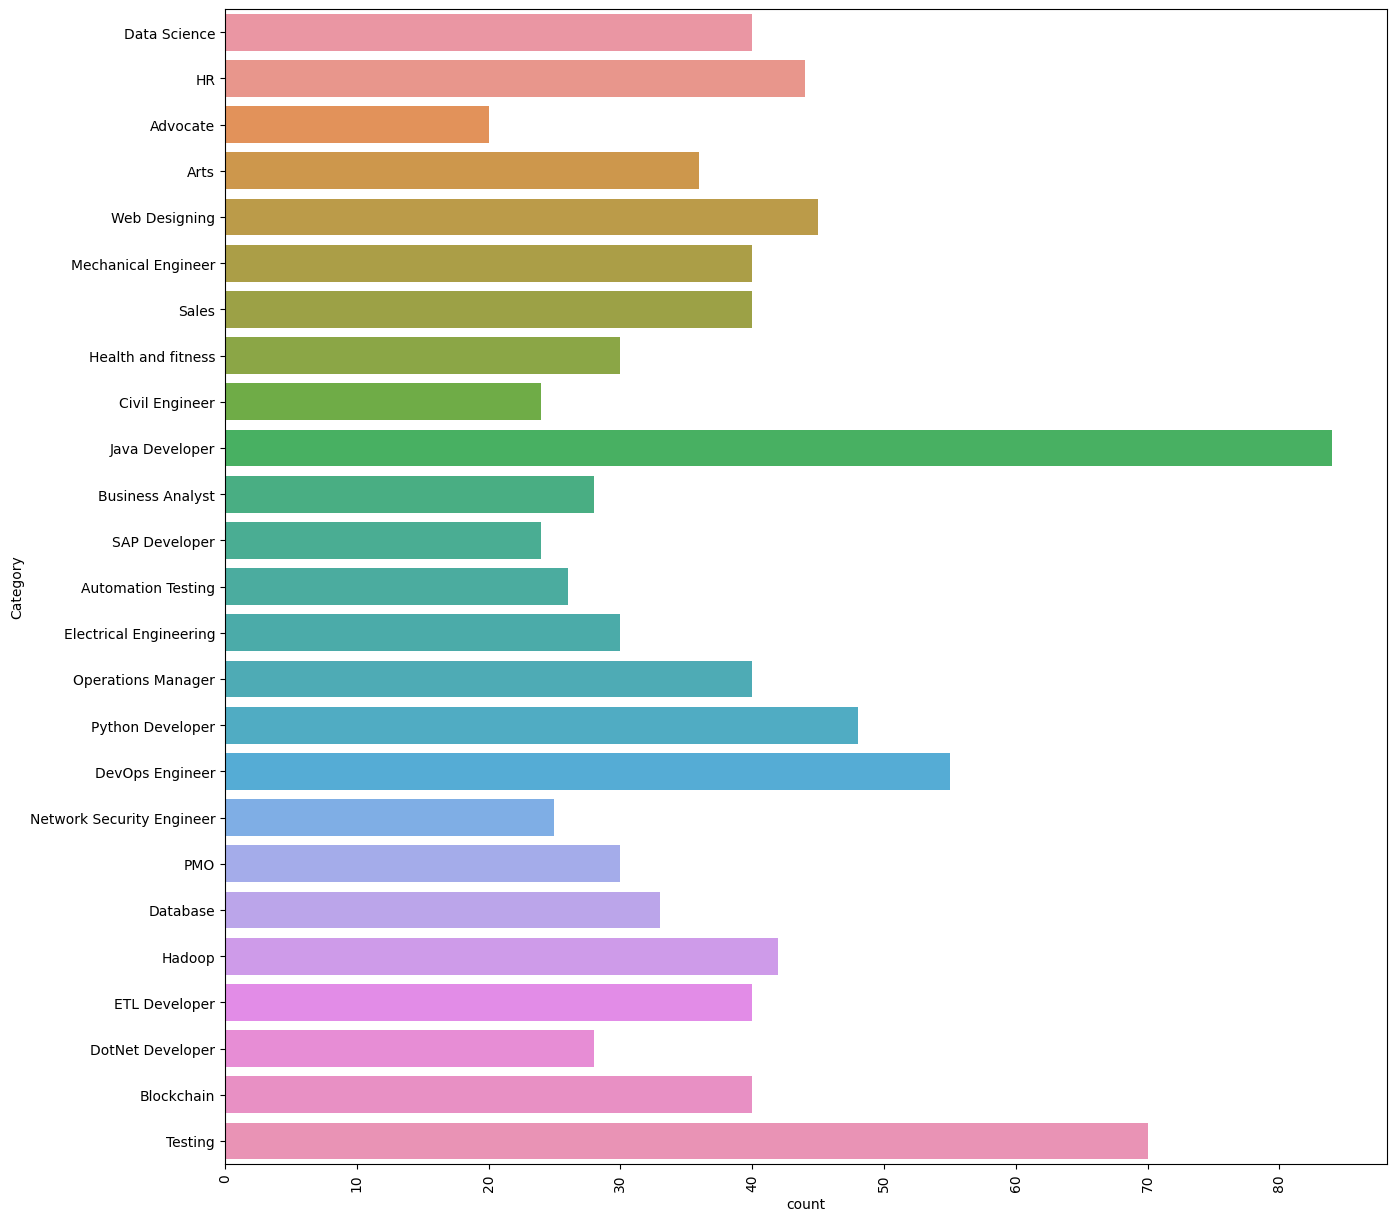

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=df)

**Create a pie plot depicting the percentage of resume distributions category-wise.(Data Visualisation)**

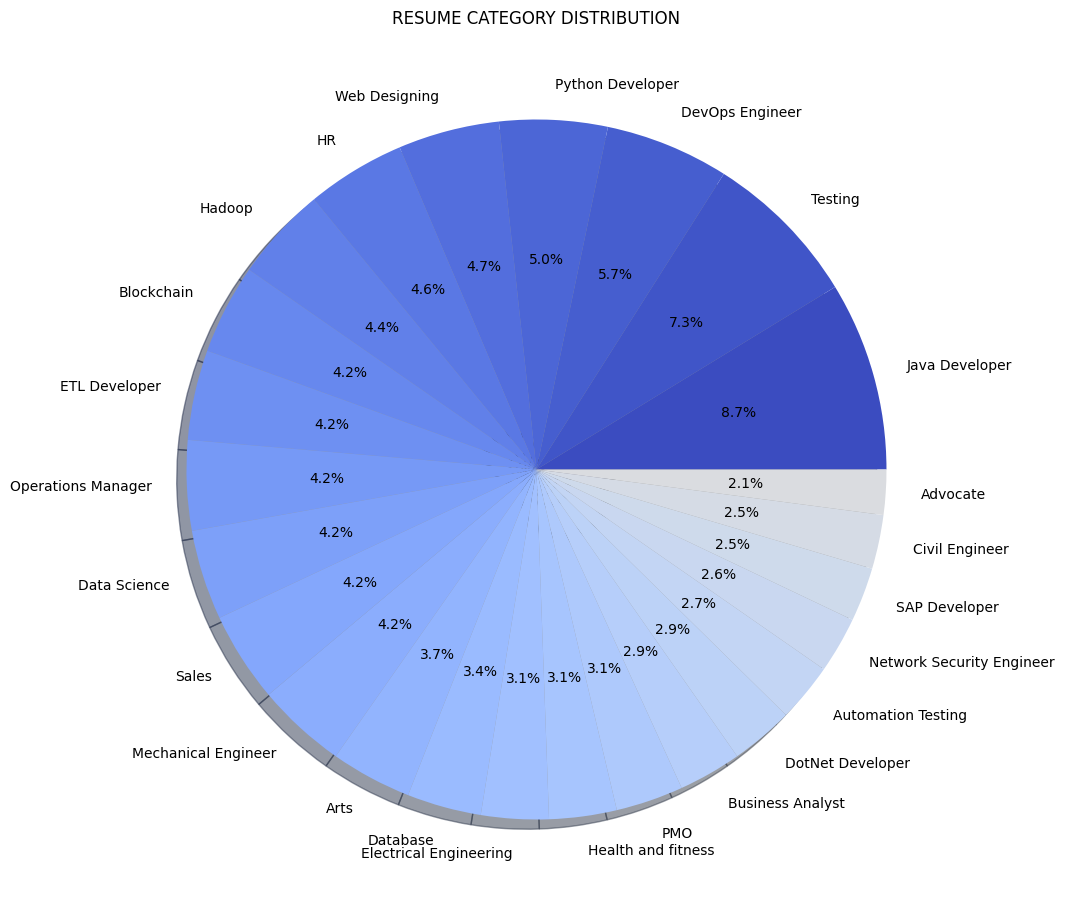

In [ ]:
targetCounts = df['Category'].value_counts()
targetLabels  = targetCounts.index
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1)]
plt.subplot(the_grid[0, 1], aspect=1, title='RESUME CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

**Exercise 5: Convert all the `Resume` text to lower case**




In [ ]:
# Convert all characters to lowercase
df['Resume']=df['Resume'].str.lower()
print(df['Resume'])

0      skills * programming languages: python (pandas...
1      education details \r\nmay 2013 to may 2017 b.e...
2      areas of interest deep learning, control syste...
3      skills â¢ r â¢ python â¢ sap hana â¢ table...
4      education details \r\n mca   ymcaust,  faridab...
                             ...                        
957    computer skills: â¢ proficient in ms office (...
958    â willingness to accept the challenges. â ...
959    personal skills â¢ quick learner, â¢ eagerne...
960    computer skills & software knowledge ms-power ...
961    skill set os windows xp/7/8/8.1/10 database my...
Name: Resume, Length: 962, dtype: object


### Cleaning Resume

**Define a function to clean the resume text**

In the text there are special characters, urls, hashtags, mentions, etc. You need to remove for the following:  

* URLs
* RT | cc
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace




In [ ]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText)
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [ ]:
df['cleaned_resume'] = df['Resume'].apply(lambda x: cleanResume(x))
print(df['cleaned_resume'][31])

education details may 2013 to may 2017 b e uit rgpv data scientist data scientist matelabs skill details python exprience less than 1 year months statsmodels exprience 12 months aws exprience less than 1 year months machine learning exprience less than 1 year months sklearn exprience less than 1 year months scipy exprience less than 1 year months keras exprience less than 1 year monthscompany details company matelabs description ml platform for business professionals dummies and enthusiasts 60 a koramangala 5th block achievements tasks behind sukh sagar bengaluru india developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction deployed automated classification and regression model linkedin com in aditya rathore b4600b146 reasearch and deployed the time series forecasting model arima sarimax holt winter and prophet worked on meta feature extracting problem github com

In [ ]:
df.head()    # data after cleaning the resume

,Category,Resume,cleaned_resume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


In [ ]:
df['cleaned_resume'][1]


'education details may 2013 to may 2017 b e uit rgpv data scientist data scientist matelabs skill details python exprience less than 1 year months statsmodels exprience 12 months aws exprience less than 1 year months machine learning exprience less than 1 year months sklearn exprience less than 1 year months scipy exprience less than 1 year months keras exprience less than 1 year monthscompany details company matelabs description ml platform for business professionals dummies and enthusiasts 60 a koramangala 5th block achievements tasks behind sukh sagar bengaluru india developed and deployed auto preprocessing steps of machine learning mainly missing value treatment outlier detection encoding scaling feature selection and dimensionality reduction deployed automated classification and regression model linkedin com in aditya rathore b4600b146 reasearch and deployed the time series forecasting model arima sarimax holt winter and prophet worked on meta feature extracting problem github co

In [ ]:
sent_lens = []
for i in df.cleaned_resume:
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))

962
2062


In [ ]:
df["Resume"][100] ,  df["cleaned_resume"][100]

('skills: natural languages: proficient in english, hindi and marathi. computer skills: proficient with ms-office, internet operation.education details \r\njanuary 2015 to january 2018 llb law mumbai, maharashtra mumbai university\r\njanuary 2015 b.m.m  mumbai, maharashtra s.k.somaiya college, mumbai university\r\n h.s.c   asmita girls junior college, maharashtra board\r\n s.s.c vidya bhawan  maharashtra board\r\nadvocate \r\n\r\nllb student and journalist\r\nskill details \r\ncompany details \r\ncompany - criminal lawyer (law firm)\r\ndescription - ',
 'skills natural languages proficient in english hindi and marathi computer skills proficient with ms office internet operation education details january 2015 to january 2018 llb law mumbai maharashtra mumbai university january 2015 b m m mumbai maharashtra s k somaiya college mumbai university h s c asmita girls junior college maharashtra board s s c vidya bhawan maharashtra board advocate llb student and journalist skill details compan

### Stop Words Removal

The stop words, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.



**Use `nltk` package to find the most common words from the `cleaned resume` column**

In [ ]:
# stop words
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
oneSetOfStopWords

{"''",
 '``',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over

In [ ]:
# most common words
totalWords =[]
Sentences = df['cleaned_resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('details', 488), ('exprience', 446), ('data', 416), ('company', 398), ('months', 394), ('description', 358), ('1', 290), ('project', 254), ('year', 252), ('january', 216), ('learning', 210), ('science', 208), ('less', 204), ('skill', 190), ('python', 176), ('maharashtra', 166), ('6', 164), ('machine', 156), ('education', 146), ('college', 146), ('arts', 144), ('university', 140), ('skills', 134), ('development', 134), ('web', 134), ('like', 126), ('analytics', 120), ('india', 120), ('management', 120), ('application', 120), ('team', 116), ('software', 116), ('using', 110), ('business', 108), ('sql', 104), ('developed', 104), ('monthscompany', 102), ('time', 100), ('used', 98), ('b', 98), ('c', 98), ('experience', 96), ('mumbai', 96), ('projects', 94), ('knowledge', 94), ('analysis', 92), ('technologies', 92), ('hr', 92), ('engineering', 90), ('pune', 90)]


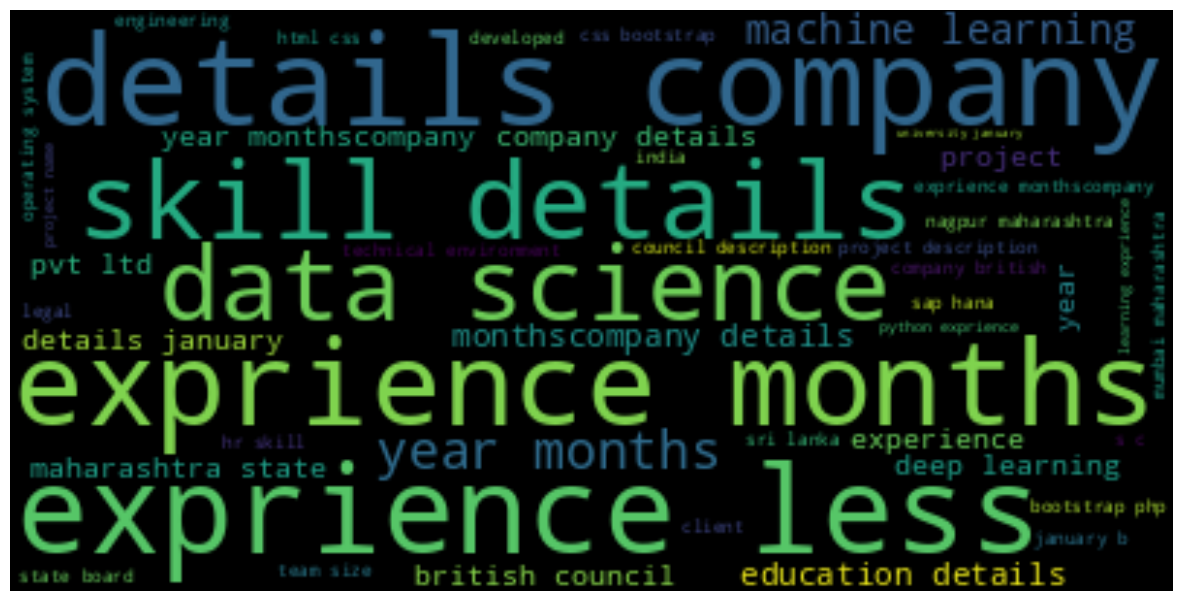

In [ ]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Convert the categorical variable `Category` to a numerical feature and make a different column, which can be treated as the target variable**



In [ ]:
labelencoder = LabelEncoder()
df["Category_Labelled"] = labelencoder.fit_transform(df["Category"])
# print(type(labels))

df.head()

,Category,Resume,cleaned_resume,Category_Labelled
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b e uit...,6
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6


### Feature Extraction

**Convert the text to feature vectors by applying `tfidf vectorizer` to the Label encoded category made above**

`TF-IDF`will tokenize documents, learn the vocabulary, inverse document frequency weightings, and allow you to encode new documents




In [ ]:
Text = df['cleaned_resume'].values
op_labels = df['Category_Labelled'].values
word_vectorizer = CountVectorizer(max_features = 1500)
word_vectorizer.fit(Text)
features = word_vectorizer.transform(Text)

## Training the model

**Split the data into train and test sets. Applying differnt models.**                                                          
**Vectorized features - features_op and Labelled category = op_label.**


**Models that are used below:**  
* Logistic Regression
* Multinomial Naive Bayes
* K-Nearest Neighbours
* Bernoullie Naive Bayes


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features,op_labels,random_state=0, test_size=0.2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression


In [ ]:
models = {
    'K-Nearest Neighbors' :  KNeighborsClassifier(n_neighbors=5),
    'BernoulliNB' : BernoulliNB(),
    'MNB' : MultinomialNB(),
    'Logistic Regression':LogisticRegression()
}




In [ ]:
for name, model in models.items():
    print(f'{name} training started...')
    model.fit(X_train, y_train)
    print(f'{name} trained')

K-Nearest Neighbors training started...
K-Nearest Neighbors trained
BernoulliNB training started...
BernoulliNB trained
MNB training started...
MNB trained
Logistic Regression training started...
Logistic Regression trained


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as CM

In [ ]:
for name,model in models.items():
    #acc_score= round(accuracy_score(y_test, models.get(name).predict(X_test)), 3)
    print(f'{name} accuracy score :{model.score(X_test,y_test)} ')

K-Nearest Neighbors accuracy score :0.9326424870466321 
BernoulliNB accuracy score :0.8238341968911918 
MNB accuracy score :0.9896373056994818 
Logistic Regression accuracy score :0.9948186528497409 


In [ ]:
for name, model in models.items():
    print(f'{name} Classification Report')

    predictions = model.predict(X_test)

    report = classification_report(y_test, predictions)
    print(report)

    print("******************************")
    print(" ")

K-Nearest Neighbors Classification Report
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       0.90      1.00      0.95         9
           4       1.00      0.83      0.91         6
           5       0.71      1.00      0.83         5
           6       0.88      0.78      0.82         9
           7       1.00      0.57      0.73         7
           8       1.00      0.91      0.95        11
           9       1.00      0.56      0.71         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         9
          12       0.56      1.00      0.71         5
          13       0.82      1.00      0.90         9
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        19
          16       0.75      1.00      

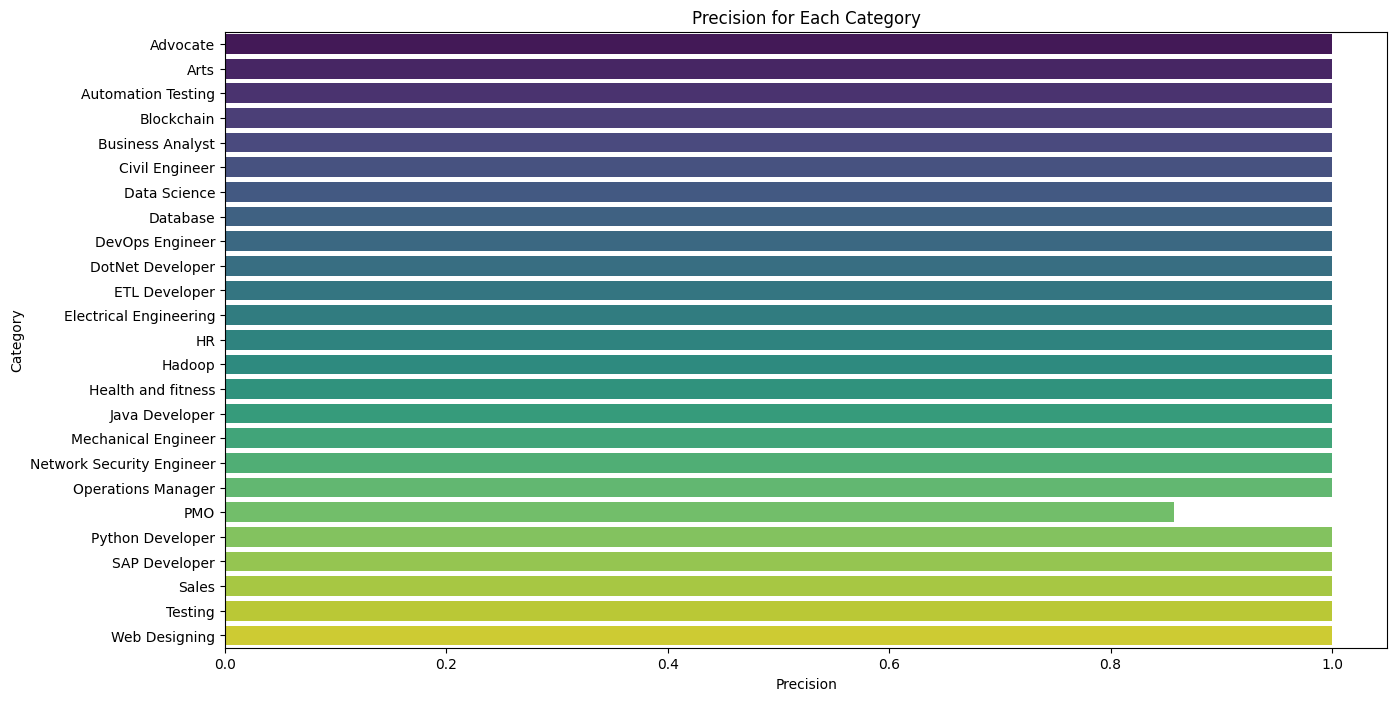

In [ ]:

# Replace 'your_model' with the actual model variable containing your predictions
model = models['Logistic Regression']  # Change this to the model you want to visualize

# Generate predictions
predictions = model.predict(X_test)

# Create a classification report
report = classification_report(y_test, predictions, target_names=labelencoder.classes_, output_dict=True)

# Extract precision values for each category
precision_data = {'Category': labelencoder.classes_, 'Precision': [report[category]['precision'] for category in labelencoder.classes_]}

# Create a DataFrame for visualization
precision_df = pd.DataFrame(precision_data)

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(x='Precision', y='Category', data=precision_df, palette='viridis')
plt.title('Precision for Each Category')
plt.xlabel('Precision')
plt.ylabel('Category')
plt.show()


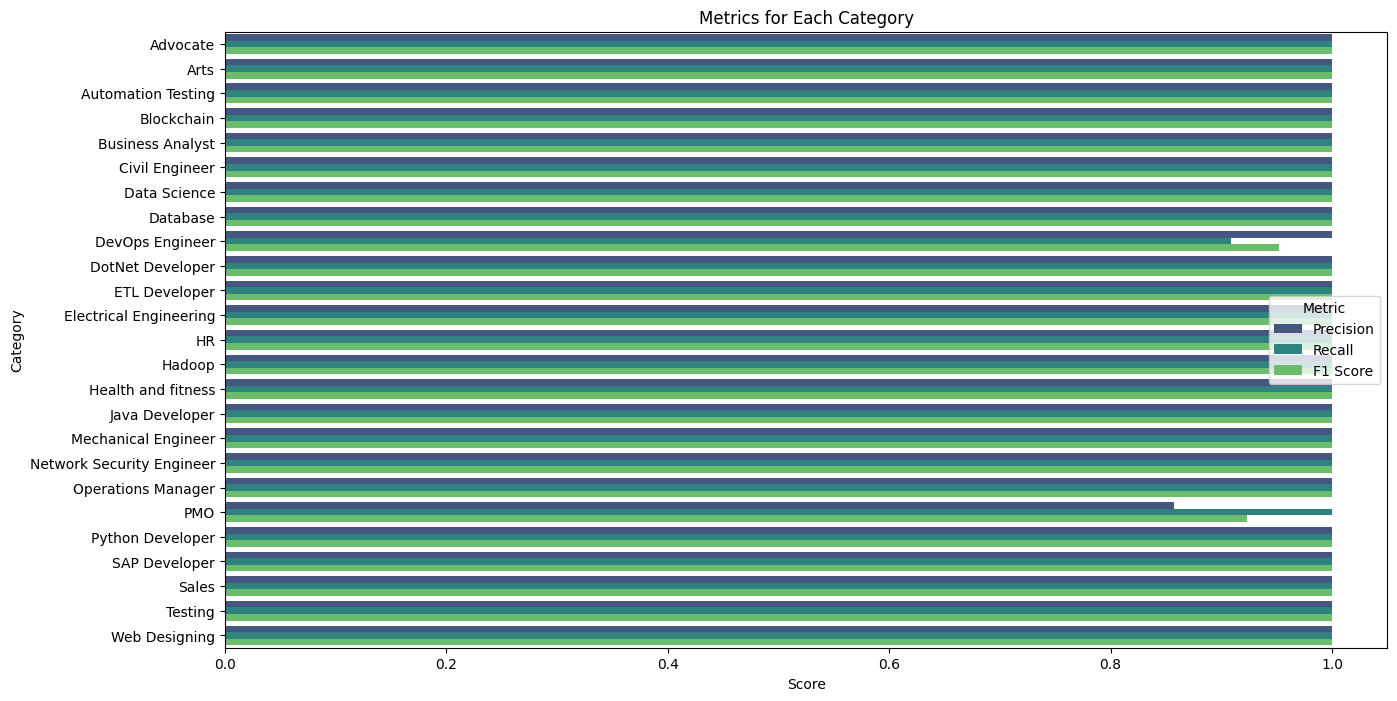

In [ ]:


# Replace 'your_model' with the actual model variable containing your predictions
model = models['Logistic Regression']  # Change this to the model you want to visualize

# Generate predictions
predictions = model.predict(X_test)

# Create a classification report
report = classification_report(y_test, predictions, target_names=labelencoder.classes_, output_dict=True)

# Extract metrics for each category
metrics_data = {'Category': labelencoder.classes_,
                'Precision': [report[category]['precision'] for category in labelencoder.classes_],
                'Recall': [report[category]['recall'] for category in labelencoder.classes_],
                'F1 Score': [report[category]['f1-score'] for category in labelencoder.classes_]}

# Create a DataFrame for visualization
metrics_df = pd.DataFrame(metrics_data)

# Melt the DataFrame for better plotting
melted_df = pd.melt(metrics_df, id_vars='Category', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(x='Score', y='Category', hue='Metric', data=melted_df, palette='viridis')
plt.title('Metrics for Each Category')
plt.xlabel('Score')
plt.ylabel('Category')
plt.show()


In [ ]:


# Initialize an empty DataFrame
precision_table = pd.DataFrame(columns=['Classifier', 'Precision'])

# Calculate precision for each classifier
for name, model in models.items():
    predictions = model.predict(X_test)
    precision = precision_score(y_test, predictions, average='weighted')
    precision_table = precision_table.append({'Classifier': name, 'Precision': precision}, ignore_index=True)

# Display the precision table
print(precision_table)


            Classifier  Precision
0  K-Nearest Neighbors   0.950455
1          BernoulliNB   0.942489
2                  MNB   0.991019
3  Logistic Regression   0.995559


In [ ]:
from sklearn.metrics import precision_score

# Loop through models and calculate precision
for name, model in models.items():
    print(f'{name} Precision for each class:')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    precision_per_class = precision_score(y_test, predictions, average=None)

    for class_index, precision in enumerate(precision_per_class):
        class_name = labelencoder.inverse_transform([class_index])[0]
        print(f'Precision for class {class_name}: {precision:.4f}')

    print("******************************")
    print(" ")


K-Nearest Neighbors Precision for each class:
Precision for class Advocate: 0.5000
Precision for class Arts: 1.0000
Precision for class Automation Testing: 1.0000
Precision for class Blockchain: 0.9000
Precision for class Business Analyst: 1.0000
Precision for class Civil Engineer: 0.7143
Precision for class Data Science: 0.8750
Precision for class Database: 1.0000
Precision for class DevOps Engineer: 1.0000
Precision for class DotNet Developer: 1.0000
Precision for class ETL Developer: 1.0000
Precision for class Electrical Engineering: 1.0000
Precision for class HR: 0.5556
Precision for class Hadoop: 0.8182
Precision for class Health and fitness: 1.0000
Precision for class Java Developer: 1.0000
Precision for class Mechanical Engineer: 0.7500
Precision for class Network Security Engineer: 1.0000
Precision for class Operations Manager: 1.0000
Precision for class PMO: 1.0000
Precision for class Python Developer: 1.0000
Precision for class SAP Developer: 1.0000
Precision for class Sales:

In [ ]:
from sklearn.metrics import recall_score

# Loop through models and calculate recall
for name, model in models.items():
    print(f'{name} Recall for each class:')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    recall_per_class = recall_score(y_test, predictions, average=None)

    for class_index, recall in enumerate(recall_per_class):
        class_name = labelencoder.inverse_transform([class_index])[0]
        print(f'Recall for class {class_name}: {recall:.4f}')

    print("******************************")
    print(" ")


K-Nearest Neighbors Recall for each class:
Recall for class Advocate: 0.6667
Recall for class Arts: 1.0000
Recall for class Automation Testing: 0.8000
Recall for class Blockchain: 1.0000
Recall for class Business Analyst: 0.8333
Recall for class Civil Engineer: 1.0000
Recall for class Data Science: 0.7778
Recall for class Database: 0.5714
Recall for class DevOps Engineer: 0.9091
Recall for class DotNet Developer: 0.5556
Recall for class ETL Developer: 1.0000
Recall for class Electrical Engineering: 1.0000
Recall for class HR: 1.0000
Recall for class Hadoop: 1.0000
Recall for class Health and fitness: 1.0000
Recall for class Java Developer: 1.0000
Recall for class Mechanical Engineer: 1.0000
Recall for class Network Security Engineer: 1.0000
Recall for class Operations Manager: 1.0000
Recall for class PMO: 1.0000
Recall for class Python Developer: 1.0000
Recall for class SAP Developer: 1.0000
Recall for class Sales: 1.0000
Recall for class Testing: 1.0000
Recall for class Web Designing:

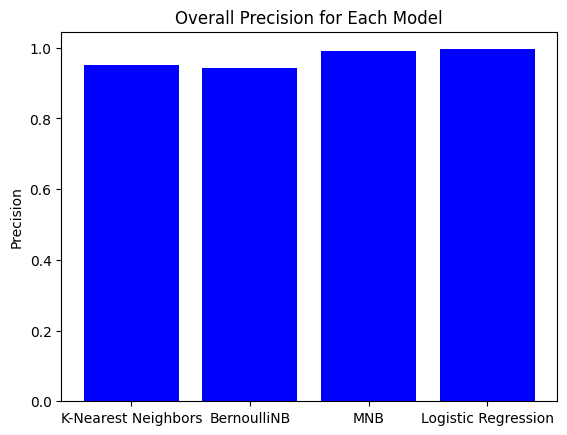

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

precision_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    precision_scores[name] = precision_score(y_test, predictions, average='weighted')

fig, ax = plt.subplots()
ax.bar(models.keys(), precision_scores.values(), color='blue')
ax.set_ylabel('Precision')
ax.set_title('Overall Precision for Each Model')
plt.show()

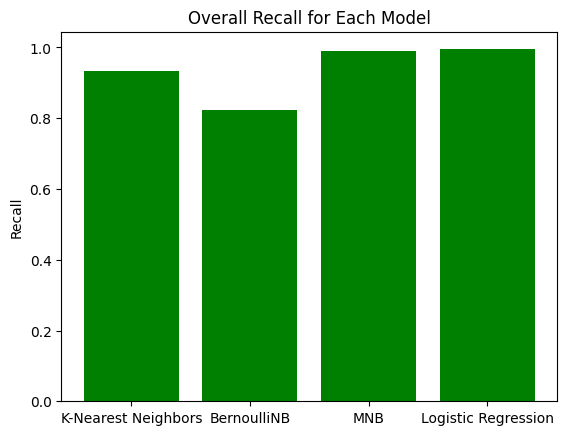

In [ ]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

recall_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    recall_scores[name] = recall_score(y_test, predictions, average='weighted')

fig, ax = plt.subplots()
ax.bar(models.keys(), recall_scores.values(), color='green')
ax.set_ylabel('Recall')
ax.set_title('Overall Recall for Each Model')
plt.show()

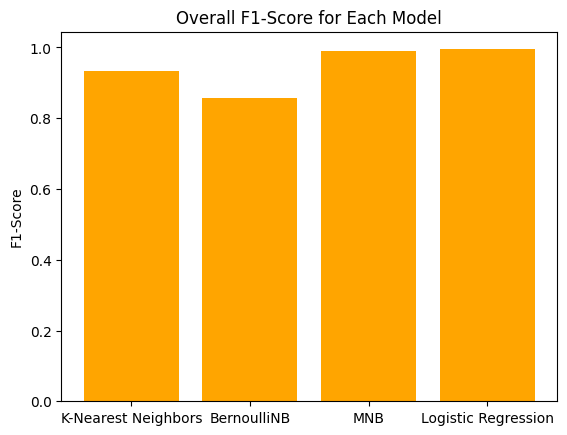

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1_scores[name] = f1_score(y_test, predictions, average='weighted')

fig, ax = plt.subplots()
ax.bar(models.keys(), f1_scores.values(), color='orange')
ax.set_ylabel('F1-Score')
ax.set_title('Overall F1-Score for Each Model')
plt.show()


In [ ]:
def prediction(text):
    x= word_vectorizer.transform([text]).toarray()
    res= model.predict(x)
    res= labelencoder.inverse_transform(res)
    print("This input belongs to",(res[0]))


Sample Resume Input


In [ ]:
prediction('''Objective
As a dedicated and result oriented professional with a strong background in project management, I am
skilled in strategic planning, problem solving and effective communication coupled with a proven track
record of delivering projects in time and within budget. By leveraging my skills to foster collaboration, I can
 drive successful outcomes for the company.

Education
Bachelor of Technology, Information & Technology Aug 2020 – April 2023
CMR UNIVERSITY, Bangalore, India GPA: 8.2/10.0
Grade 12, Central Board of Secondary Education (CBSE) April 2020
Narayana E-Techno School, Bangalore, India PERCENT: 68 %
Grade 10, Central Board of Secondary Education (CBSE) April 2018
Indian Public School, Bangalore, India PERCENT: 73.4%
Projects and Internship
IBM SkillsBuild CyberSecurity Jan 2023 – Feb 2023, Bengaluru, India
 Studied CyberSecurity Fundamentals and important concepts such as:
o Threat Intelligence
o Cybersecurity as a defence
o Security Strategies
o Risk Management
 Earned digital credits on completing the sub courses.
 Obtained the online course completion certificate.
Skills
 C programing Language
 Cloud Computing Fundamentals
 Analytical Thinking
 Critical Thinking
 Verbal and Written Communication
Hobbies
 Photography
 Digital Art
 Cinematography
 Badminton
Certifications
 Certified in Artificial Intelligence Introduction ,by Symposium IIT Mumbai|2022
 Certified as a Secure Computer User,by EHack Academy |2023
''')

This input belongs to HR
